In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
os.listdir('/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images')

['Mild', 'Proliferate_DR', 'Moderate', 'No_DR', 'Severe']

In [3]:
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image

In [4]:
def load_imgs(impath):
    imgs=[]
    label=[]
    l1=os.listdir(impath)
    for i in l1:
        c=0
        l2=os.listdir(impath+'/'+i)
        for j in l2:
            if c<=1000:
                img=Image.open(impath+i+'/'+j)
                img=img.resize(size=(32,32))
                #img=img.convert('L')
                #img=np.array(img,dtype=np.float16)/255
                imgs.append(np.array(img)) #.flatten())
                label.append(i)
                del img
                c=c+1

        '''if(c%1000==0):
            plt.imshow(img)
            plt.show()
            c=c+1'''
    return np.array(imgs),label

In [5]:
x,y=load_imgs('/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images/')
x.shape,len(y)

((2858, 32, 32, 3), 2858)

In [6]:
target=pd.Series(y,dtype='category')
target

0         Mild
1         Mild
2         Mild
3         Mild
4         Mild
         ...  
2853    Severe
2854    Severe
2855    Severe
2856    Severe
2857    Severe
Length: 2858, dtype: category
Categories (5, object): ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [7]:
target.value_counts()

No_DR             1001
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
dtype: int64

In [8]:
t=target.cat.codes
t

0       0
1       0
2       0
3       0
4       0
       ..
2853    4
2854    4
2855    4
2856    4
2857    4
Length: 2858, dtype: int8

In [9]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y=train_test_split(x,t,test_size=0.2,shuffle=True)
train_x.shape,test_x.shape,train_y.shape,test_y.shape

((2286, 32, 32, 3), (572, 32, 32, 3), (2286,), (572,))

In [10]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
#from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model

from tensorflow.keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [11]:
def bottleneck_residual_block(X, f, filters, stage, block, reduce=False, s=2):
    """    
    Arguments:
    X -- input tensor of shape (m, height, width, channels)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    reduce -- boolean, True = identifies the reduction layer at the beginning of each learning stage
    s -- integer, strides
    
    Returns:
    X -- output of the identity block, tensor of shape (H, W, C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    if reduce:
        # if we are to reduce the spatial size, apply a 1x1 CONV layer to the shortcut path
        # to do that, we need both CONV layers to have similar strides 
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)
        
        X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    else: 
        # First component of main path
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0), kernel_regularizer='L2')(X)
        X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0),kernel_regularizer='L2')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0),kernel_regularizer='L2')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    
    #extra

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X


In [12]:
def ResNet50(input_shape, classes):
    """
    Arguments:
    input_shape -- tuple shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    X = Dropout(0.2)(X)


    # Stage 2
    X = bottleneck_residual_block(X, 3, [64, 64, 256], stage=2, block='a', reduce=True, s=1)
    X = bottleneck_residual_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = bottleneck_residual_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = Dropout(0.2)(X)

    # Stage 3 
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='a', reduce=True, s=2)
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = Dropout(0.2)(X)

    # Stage 4 
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='a', reduce=True, s=2)
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = Dropout(0.2)(X)

    # Stage 5 
    X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='a', reduce=True, s=2)
    X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    X = AveragePooling2D((1,1), name="avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create the model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model


In [13]:
model = ResNet50(input_shape = (32,32, 3), classes = 5)

2022-12-11 19:24:53.140154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 19:24:53.141054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 19:24:53.324332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 19:24:53.325180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 19:24:53.325980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [14]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 13, 13, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 13, 13, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 13, 13, 64)   0           bn_conv1[0][0]                   
___________________________________________________________________________________________

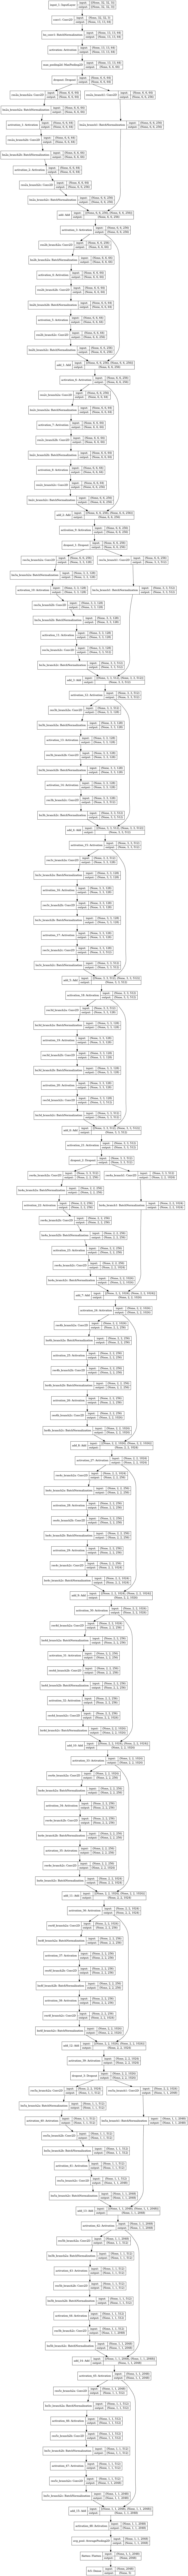

In [16]:
plot_model(model,to_file='resnet.png',show_shapes=True)

In [17]:
train_x.shape

(2286, 32, 32, 3)

In [18]:
train_y.shape

(2286,)

In [19]:
model.fit(train_x, train_y, epochs = 50, batch_size = 32, shuffle=True) 

2022-12-11 19:25:01.028934: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-12-11 19:25:08.571161: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


72/72 [==============================] - 19s 52ms/step - loss: 118.7839 - accuracy: 0.4484
Epoch 2/50
72/72 [==============================] - 3s 45ms/step - loss: 76.7095 - accuracy: 0.5451
Epoch 3/50
72/72 [==============================] - 3s 41ms/step - loss: 49.0165 - accuracy: 0.6146
Epoch 4/50
72/72 [==============================] - 3s 40ms/step - loss: 34.1028 - accuracy: 0.5774
Epoch 5/50
72/72 [==============================] - 3s 40ms/step - loss: 24.7704 - accuracy: 0.5967
Epoch 6/50
72/72 [==============================] - 3s 43ms/step - loss: 19.2928 - accuracy: 0.5936
Epoch 7/50
72/72 [==============================] - 3s 46ms/step - loss: 15.1826 - accuracy: 0.6076
Epoch 8/50
72/72 [==============================] - 3s 40ms/step - loss: 12.7469 - accuracy: 0.6006
Epoch 9/50
72/72 [==============================] - 3s 43ms/step - loss: 11.1157 - accuracy: 0.6006
Epoch 10/50
72/72 [==============================] - 3s 40ms/step - loss: 10.7249 - accuracy: 0.5949
Epoch 11

In [20]:
model.evaluate(test_x,test_y)

18/18 [==============================] - 2s 38ms/step - loss: 25342482432.0000 - accuracy: 0.3444


[25342482432.0, 0.3444055914878845]